In [1]:
import pandas as pd
import numpy as np

from keras import optimizers, losses, activations, models
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from keras.layers import Dense, Input, Dropout, Convolution1D, MaxPool1D, GlobalMaxPool1D, GlobalAveragePooling1D, concatenate
from sklearn.metrics import f1_score, accuracy_score

import tensorflow as tf
from keras import Input, Model, layers
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras import losses
from tensorflow import keras
from keras.callbacks import EarlyStopping

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv1D, GlobalAveragePooling1D, MaxPooling1D
from keras import regularizers
from keras.utils import np_utils
from keras import utils
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

import pywt
from sklearn.metrics import roc_auc_score, RocCurveDisplay, average_precision_score, PrecisionRecallDisplay, auc

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Gloabal variables
data_path = "../input/"
model_path = "../../H5/PTB/CNN_ptb.h5"

train = False

In [3]:
# read the dataset
df_1 = pd.read_csv(data_path + "ptbdb_normal.csv", header=None)
df_2 = pd.read_csv(data_path + "ptbdb_abnormal.csv", header=None)
df = pd.concat([df_1, df_2])

df_train, df_test = train_test_split(df, test_size=0.2, random_state=1337, stratify=df[187])


y_train = np.array(df_train[187].values).astype(np.int8)
X_train = np.array(df_train[list(range(187))].values)[..., np.newaxis]

y_test = np.array(df_test[187].values).astype(np.int8)
X_test = np.array(df_test[list(range(187))].values)[..., np.newaxis]

In [4]:
# create the model
model = Sequential()
model.add(Conv1D(16, 10, activation='relu', input_shape=(187, 1)))
model.add(MaxPooling1D(2))
model.add(Dropout(0.))
model.add(Conv1D(32, 5, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.2))
model.add(Conv1D(64, 10, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.5))
model.add(Conv1D(128, 2, activation='relu'))
model.add(GlobalAveragePooling1D())
# model.add(Flatten())
model.add(Dense(128, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(256, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, kernel_initializer='normal', activation='softmax'))

# model.summary()

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss=losses.sparse_categorical_crossentropy, metrics=['acc'])

tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)
print("Number of weights: {}".format(model.count_params()))

Number of weights: 106386


In [5]:
callbacks = [ModelCheckpoint(model_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max'),
             ReduceLROnPlateau(monitor="val_acc", mode="max", patience=3, verbose=2),
             EarlyStopping(monitor="val_acc", mode="max", patience=15, verbose=1)]

if train:
    history = model.fit(X_train, y_train, epochs=250, verbose=2, callbacks=callbacks, validation_split=0.1)

Epoch 1/250

Epoch 1: val_acc improved from -inf to 0.75279, saving model to /content/drive/MyDrive/MLHC_PROJECT1/CNN.h5
328/328 - 12s - loss: 0.5291 - acc: 0.7408 - val_loss: 0.4889 - val_acc: 0.7528 - lr: 0.0010 - 12s/epoch - 37ms/step
Epoch 2/250

Epoch 2: val_acc improved from 0.75279 to 0.83004, saving model to /content/drive/MyDrive/MLHC_PROJECT1/CNN.h5
328/328 - 1s - loss: 0.4216 - acc: 0.8087 - val_loss: 0.3886 - val_acc: 0.8300 - lr: 0.0010 - 1s/epoch - 4ms/step
Epoch 3/250

Epoch 3: val_acc improved from 0.83004 to 0.85408, saving model to /content/drive/MyDrive/MLHC_PROJECT1/CNN.h5
328/328 - 1s - loss: 0.3616 - acc: 0.8436 - val_loss: 0.3316 - val_acc: 0.8541 - lr: 0.0010 - 1s/epoch - 4ms/step
Epoch 4/250

Epoch 4: val_acc did not improve from 0.85408
328/328 - 1s - loss: 0.3194 - acc: 0.8665 - val_loss: 0.3515 - val_acc: 0.8429 - lr: 0.0010 - 1s/epoch - 4ms/step
Epoch 5/250

Epoch 5: val_acc improved from 0.85408 to 0.90129, saving model to /content/drive/MyDrive/MLHC_PROJE

In [6]:
model.load_weights(model_path)

pred_test = model.predict(X_test)
pred_test = np.argmax(pred_test, axis=-1)

f1 = f1_score(y_test, pred_test, average="macro")

print("Test f1 score : %s "% f1)

acc = accuracy_score(y_test, pred_test)

print("Test accuracy score : %s "% acc)

Test f1 score : 0.9695305194895818 
Test accuracy score : 0.9752662315355548 


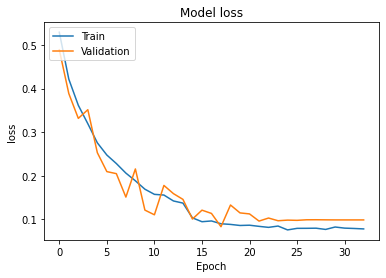

In [7]:
if train:
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

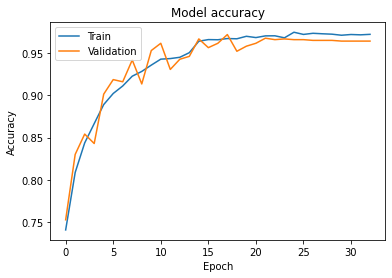

In [8]:
if train:
    # Plot training & validation accuracy values
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

Model AUROC: 0.9748897100765767


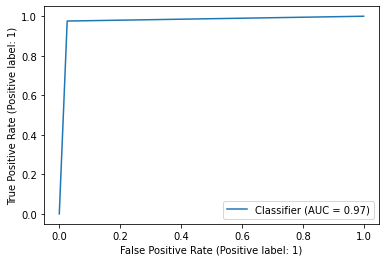

In [9]:
RocCurveDisplay.from_predictions(y_test.reshape(-1,1), pred_test)
print("Model AUROC: {}".format(roc_auc_score(y_test.reshape(-1,1), pred_test, average=None)))

Model AUPRC: 0.9833679152873571


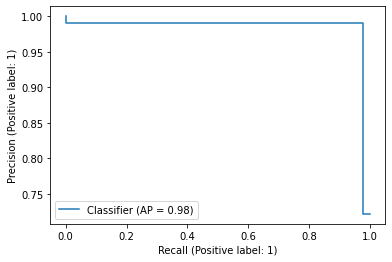

In [10]:
PrecisionRecallDisplay.from_predictions(y_test.reshape(-1,1), pred_test)
print("Model AUPRC: {}".format(average_precision_score(y_test.reshape(-1,1), pred_test)))

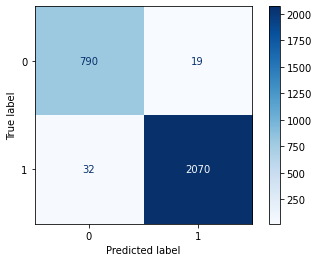

In [ ]:
# Plotting confusion matrix
cm = confusion_matrix(y_test, pred_test)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3])

disp.plot(cmap=plt.cm.Blues)
plt.show()